In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, FloatType, StructField, StructType, ArrayType, DoubleType, MapType, IntegerType
import pyspark.sql.functions as f

import string

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [2]:
#create env for JAVA_HOME
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk1.8.0_202"

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[1]")\
        .appName("FP_BDPAL")\
        .getOrCreate()

spark
sc = spark.sparkContext

In [4]:
nltk.download('stopwords')
nltk.download('vader_lexicon')
stopwordsEnglish = stopwords.words('english')
nltk.data.path.append('C:/Users/AZIS/AppData/Roaming/nltk_data')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AZIS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\AZIS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Import Data

In [5]:
df_hotelReviews = spark.read.csv('./Hotel_Reviews.csv', header=True, inferSchema=True)

df_hotelReviews.printSchema()

df_hotelReviews.show(5)

root
 |-- Hotel_Address: string (nullable = true)
 |-- Additional_Number_of_Scoring: integer (nullable = true)
 |-- Review_Date: string (nullable = true)
 |-- Average_Score: double (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)
 |-- Negative_Review: string (nullable = true)
 |-- Review_Total_Negative_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews: integer (nullable = true)
 |-- Positive_Review: string (nullable = true)
 |-- Review_Total_Positive_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews_Reviewer_Has_Given: integer (nullable = true)
 |-- Reviewer_Score: double (nullable = true)
 |-- Tags: string (nullable = true)
 |-- days_since_review: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)

+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+-----------------

## 2. Data Preprocessing

In [6]:
df_hotelReviews = df_hotelReviews.withColumn("review", f.concat(df_hotelReviews["Negative_Review"], df_hotelReviews["Positive_Review"]))
df_hotelReviews.select("review").show(5)

+--------------------+
|              review|
+--------------------+
| I am so angry th...|
|No Negative No re...|
| Rooms are nice b...|
| My room was dirt...|
| You When I booke...|
+--------------------+
only showing top 5 rows



In [7]:
df_hotelReviews = df_hotelReviews.withColumn('is_bad_review', f.when(df_hotelReviews['Reviewer_Score'] < 5, 1).otherwise(0))
df_hotelReviews.select("is_bad_review").show(5)

+-------------+
|is_bad_review|
+-------------+
|            1|
|            0|
|            0|
|            1|
|            0|
+-------------+
only showing top 5 rows



In [8]:
reviews = df_hotelReviews.select("review", "is_bad_review")
reviews.show(5)

+--------------------+-------------+
|              review|is_bad_review|
+--------------------+-------------+
| I am so angry th...|            1|
|No Negative No re...|            0|
| Rooms are nice b...|            0|
| My room was dirt...|            1|
| You When I booke...|            0|
+--------------------+-------------+
only showing top 5 rows



In [9]:
sample_reviews = reviews.sample(False, 0.1, seed=42)

In [10]:
sample_reviews = sample_reviews.withColumn("review", f.regexp_replace(f.col("review"), "No Negative", ""))
sample_reviews = sample_reviews.withColumn("review", f.regexp_replace(f.col("review"), "No Positive", ""))
sample_reviews.show(5)

+--------------------+-------------+
|              review|is_bad_review|
+--------------------+-------------+
| Apart from the p...|            0|
| Very steep steps...|            0|
| Public areas are...|            0|
| The bar was shut...|            0|
| The hotel is und...|            0|
+--------------------+-------------+
only showing top 5 rows



In [11]:
def cleanText(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [t for t in text if len(t) > 0]
    text = [word for word in text if word not in stopwordsEnglish]
    text = [WordNetLemmatizer().lemmatize(t) for t in text]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return text
    return text

In [12]:
udfCleanText = f.udf(cleanText, StringType())
sample_reviews = sample_reviews.withColumn("review_clean", udfCleanText(f.col("review")))
sample_reviews.select("review_clean").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_clean                                                                                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|apart price brekfast everything good good location set lovely park friendly staff food high quality oth enjoyed breakfast                                                                                |
|steep step room bed safe child asked move room put another identical one room decoration minamilist like felt prison cell sparse great onsite cafe amazing building park location amazi

## 3. Feature Engineering

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def getSentimentScore(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    return vs

udfSentimentScore = f.udf(getSentimentScore, MapType(keyType=StringType(), valueType=DoubleType()))

In [14]:
#make column sentiments
sample_reviews = sample_reviews.withColumn("sentiments", udfSentimentScore(f.col("review")))

In [15]:
#make columns for each sentiment data
sample_reviews = sample_reviews.withColumn("neg", sample_reviews.sentiments.getItem('neg')) \
                      .withColumn("neu", sample_reviews.sentiments.getItem('neu')) \
                      .withColumn("pos", sample_reviews.sentiments.getItem('pos')) \
                      .withColumn("compound", sample_reviews.sentiments.getItem('compound'))

In [16]:
#remove the column sentiments
sample_reviews = sample_reviews.select([c for c in sample_reviews.columns if c != "sentiments"])

In [17]:
# count characters
sample_reviews = sample_reviews.withColumn("char_count", f.length(f.col("review")))

# count words
sample_reviews = sample_reviews.withColumn("word_count", f.size(f.split(f.col("review"), " ")))

In [18]:
# TF-IDF
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, HashingTF, IDFModel, Word2Vec
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="review_clean", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
pipelineFit = pipeline.fit(sample_reviews)
sample_reviews = pipelineFit.transform(sample_reviews)

sample_reviews.show(5)

+--------------------+-------------+--------------------+-----+-----+-----+--------+----------+----------+--------------------+--------------------+--------------------+
|              review|is_bad_review|        review_clean|  neg|  neu|  pos|compound|char_count|word_count|               words|         rawFeatures|            features|
+--------------------+-------------+--------------------+-----+-----+-----+--------+----------+----------+--------------------+--------------------+--------------------+
| Apart from the p...|            0|apart price brekf...|  0.0|0.557|0.443|  0.9491|       157|        29|[apart, price, br...|(262144,[25789,43...|(262144,[25789,43...|
| Very steep steps...|            0|steep step room b...|0.095|0.631|0.274|   0.928|       270|        51|[steep, step, roo...|(262144,[3280,110...|(262144,[3280,110...|
| Public areas are...|            0|public area lovel...|0.106|0.692|0.201|  0.4019|       166|        33|[public, area, lo...|(262144,[11941,22...|(2

## 4. EDA

In [19]:
value_counts = sample_reviews.groupBy("is_bad_review").count().show()

+-------------+-----+
|is_bad_review|count|
+-------------+-----+
|            1| 2163|
|            0|49387|
+-------------+-----+



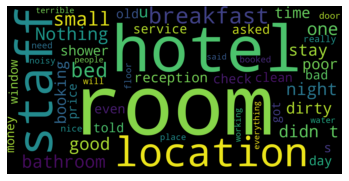

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# select data with is_bad_review = 1
text_data = sample_reviews.filter(f.col("is_bad_review") == 1).select("review").rdd.map(lambda row: row[0]).collect()
text = " ".join(text_data)

# make wordcloud
wordcloud = WordCloud(background_color='black', width=1600, height=800, max_words=50).generate(text)

# show wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
sample_reviews.filter(f.col("word_count") >= 5).orderBy(f.col("pos").desc()).select("review", "pos").show(10, truncate=False)

+-------------------------------------------------+-----+
|review                                           |pos  |
+-------------------------------------------------+-----+
| clean comfortable attractive                    |1.0  |
| Excellent service super comfortable             |0.916|
| Best location comfortable clean                 |0.911|
| Helpful friendly great staff                    |0.91 |
| happy friendly helpful staff                    |0.907|
| Great hotel good value                          |0.904|
| breakfast excellent Clean comfort               |0.899|
| Clean comfortable good facilities               |0.899|
| Nice clean and friendly                         |0.897|
| Great value great location clean and comfortable|0.892|
+-------------------------------------------------+-----+
only showing top 10 rows



In [31]:
sample_reviews.filter(f.col("word_count") >= 5).orderBy(f.col("neg").desc()).select("review", "neg").show(10)

+--------------------+-----+
|              review|  neg|
+--------------------+-----+
| Nothing Thanks I...|0.844|
| Nothing  Great h...|0.812|
| dirty old bad fo...|0.802|
| Nothing Excellen...|0.799|
|      Noisy no view |0.796|
| Nothing Comforta...|0.786|
|     Nothing  Great |0.767|
| Nothing  Excelle...|0.763|
| Nothing  Beautiful |0.759|
| poor facility po...|0.756|
+--------------------+-----+
only showing top 10 rows



C:\Users\AZIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AZIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


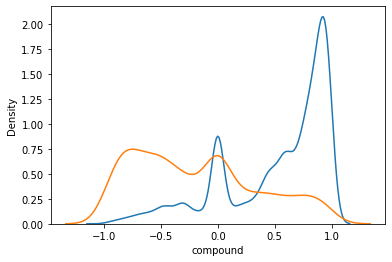

In [38]:
import seaborn as sns

pandasReviews = sample_reviews.select("compound", "is_bad_review").toPandas()

for x in [0, 1]:
    subset = pandasReviews[pandasReviews["is_bad_review"] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

plt.show()

## Testing

In [22]:
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [23]:
# assembler = VectorAssembler(inputCols=["neg", "neu", "pos", "compound", "char_count", "word_count", "features"], outputCol="features_vec")

In [24]:
# lr = LogisticRegression(featuresCol="features_vec", labelCol="is_bad_review")

In [25]:
# pipeline = Pipeline(stages=[assembler, lr])

In [26]:
# train, test = sample_reviews.randomSplit([0.7, 0.3], seed=42)

In [27]:
# model = pipeline.fit(train)

In [28]:
# predictions = model.transform(test)

In [29]:
# evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="is_bad_review")
# evaluator.evaluate(predictions)